<a href="https://colab.research.google.com/github/matheusTA/SnakeGame/blob/master/detected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

path = '/content/gdrive/MyDrive/dataset/'

Mounted at /content/gdrive


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    fill_mode = "nearest"
)

data_generator_test = ImageDataGenerator(rescale = 1./255)

In [3]:
train_generator = data_generator_train.flow_from_directory(
    directory = path + 'train',
    target_size = (120, 120),
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = 32,
    seed = 42,
    shuffle = True
)

Found 7097 images belonging to 4 classes.


In [4]:
test_generator = data_generator_test.flow_from_directory(
    directory = path + 'test',
    target_size = (120, 120),
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = 32,
    seed = 42,
    shuffle = True
)

Found 771 images belonging to 4 classes.


In [5]:
valid_generator = data_generator_test.flow_from_directory(
    directory = path + 'val',
    target_size = (120, 120),
    color_mode = "grayscale",
    class_mode = None,
    batch_size = 1,
    seed = 42,
    shuffle = False
)

Found 38 images belonging to 4 classes.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

model = Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(120, 120, 1)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(kernel_size=(3,3), filters=64, activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(kernel_size=(3,3), filters=128, activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 118, 118, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 128)     

In [18]:
EPOCHS = 15
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

In [19]:
model_history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test_generator,
    validation_steps=STEP_SIZE_TEST,
    epochs=EPOCHS,
    verbose= 1
)

Epoch 1/15
221/221 [==============================] - 123s 551ms/step - loss: 0.7891 - accuracy: 0.6820 - val_loss: 0.5618 - val_accuracy: 0.7630
Epoch 2/15
221/221 [==============================] - 122s 552ms/step - loss: 0.5186 - accuracy: 0.7979 - val_loss: 0.4599 - val_accuracy: 0.8255
Epoch 3/15
221/221 [==============================] - 121s 548ms/step - loss: 0.4531 - accuracy: 0.8326 - val_loss: 0.4302 - val_accuracy: 0.8542
Epoch 4/15
221/221 [==============================] - 121s 546ms/step - loss: 0.4009 - accuracy: 0.8501 - val_loss: 0.3847 - val_accuracy: 0.8581
Epoch 5/15
221/221 [==============================] - 121s 548ms/step - loss: 0.3469 - accuracy: 0.8696 - val_loss: 0.5094 - val_accuracy: 0.8203
Epoch 6/15
221/221 [==============================] - 121s 546ms/step - loss: 0.3107 - accuracy: 0.8846 - val_loss: 0.3991 - val_accuracy: 0.8464
Epoch 7/15
221/221 [==============================] - 121s 548ms/step - loss: 0.3016 - accuracy: 0.8880 - val_loss: 0.3837 -

In [20]:
model.evaluate(test_generator, steps=STEP_SIZE_TEST)

24/24 [==============================] - 11s 456ms/step - loss: 0.2461 - accuracy: 0.9141


[0.24609030783176422, 0.9140625]

In [21]:
model.save("XrayClassification")

INFO:tensorflow:Assets written to: XrayClassification/assets


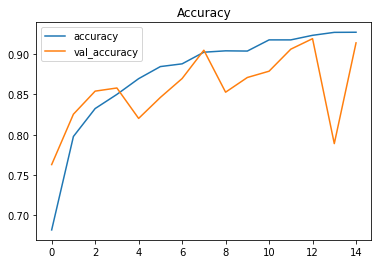

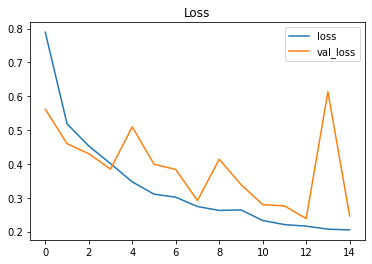

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(model_history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy") 
plt.show()

pd.DataFrame(model_history.history)[['loss','val_loss']].plot()
plt.title("Loss") 
plt.show() 

38/38 [==============================] - 1s 29ms/step
Confusion Matrix


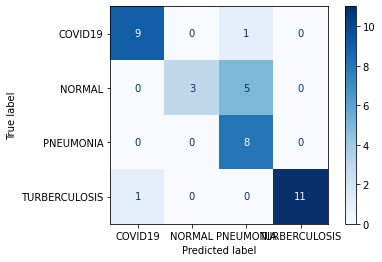

Classification Report
               precision    recall  f1-score   support

      COVID19       0.90      0.90      0.90        10
       NORMAL       1.00      0.38      0.55         8
    PNEUMONIA       0.57      1.00      0.73         8
TURBERCULOSIS       1.00      0.92      0.96        12

     accuracy                           0.82        38
    macro avg       0.87      0.80      0.78        38
 weighted avg       0.88      0.82      0.81        38



In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


valid_generator.reset()

pred = model.predict(valid_generator, steps=STEP_SIZE_VALID, verbose=1)

predicted_class_indices = np.argmax(pred, axis=1)

target_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

print('Confusion Matrix')
cllt = confusion_matrix(valid_generator.classes, predicted_class_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cllt, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()


print('Classification Report')

print(classification_report(valid_generator.classes, predicted_class_indices, target_names=target_names))

A acc nas imagens de teste é 81.58%.


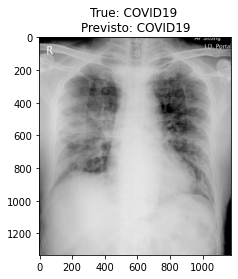

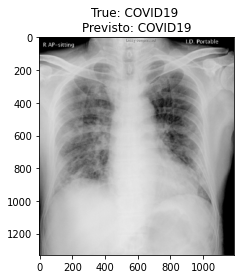

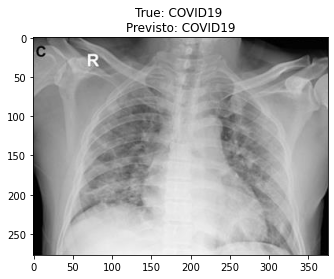

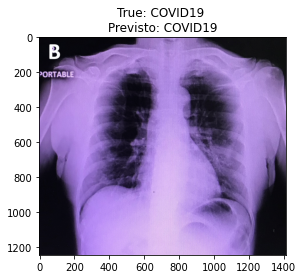

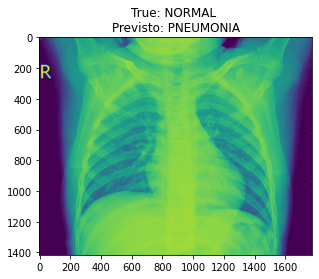

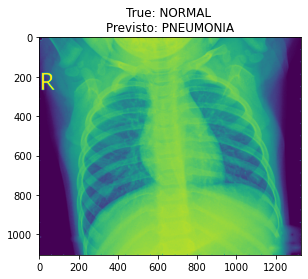

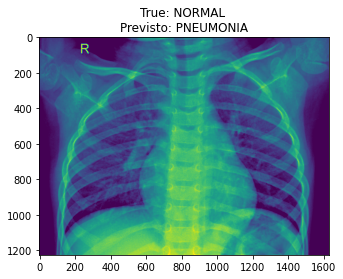

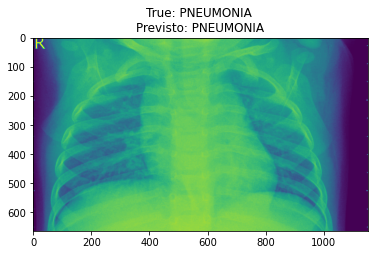

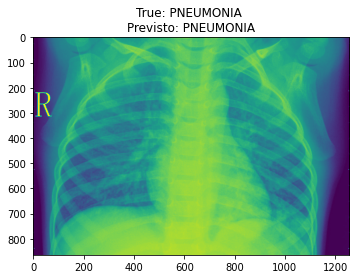

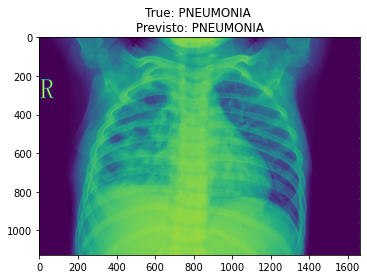

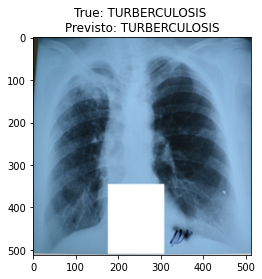

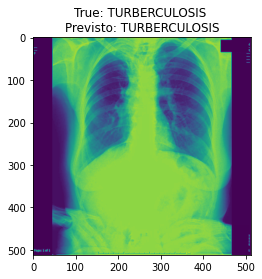

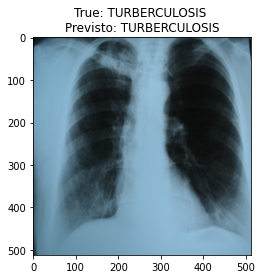

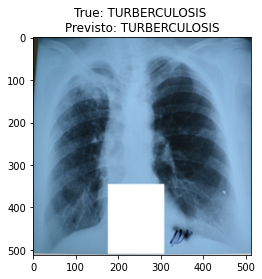

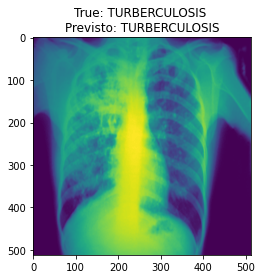

In [40]:
import matplotlib.pyplot as plt

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

current_idx = 0
count_accurate = 0
Actual = []

for i in predictions:
    string = valid_generator.filenames[current_idx]
    substr = '/'
    actual = string[:string.find(substr)]
    Actual.append(actual)
    pred = predictions[current_idx]
    if actual == pred: 
        count_accurate += 1
    current_idx += 1

acc = count_accurate/38

print(f"A acc nas imagens de teste é {round(acc*100,2)}%.")

current = [1, 2, 3, 5, 10, 15, 16, 20, 22, 25, 28, 30, 33, 35, 37]

for i in current: 
    plt.imshow(plt.imread(path + 'val/' + valid_generator.filenames[i]))
    string = valid_generator.filenames[i]
    substr = '/'
    actual = string[:string.find(substr)]
    plt.title(f"True: {actual} \nPrevisto: {predictions[i]}")
    plt.show()